In [1]:
cd /content/drive/MyDrive/object-detection/mnist

/content/drive/MyDrive/object-detection/mnist


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import utils
import importlib
from tqdm.notebook import tqdm 

importlib.reload(utils)

<module 'utils' from '/content/drive/My Drive/object-detection/mnist/utils.py'>

In [3]:
#@title utils
# utils
import matplotlib.pyplot as plt
from pathlib import Path as p
from datetime import datetime
import pickle

def plot_and_save(a, file_path):
    fig, ax = plt.subplots()
    ax.plot(a)  
    fig.savefig(file_path)
    plt.close(fig)

def folder(path):
    path.mkdir(exist_ok=True, parents=True)
    return path

def pickle_save(x, file):
    with open(file, 'wb') as f:
        pickle.dump(x, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()
    
def pickle_load(file):
    with open(file, 'rb') as f:
        x = pickle.load(f)
    f.close()
    return x

result_folder = p.cwd()/'results'
current_time = datetime.now().strftime("%m-%d__%H-%M-%S")
# current_time = '08-30__10-45-36'
output_folder = folder(result_folder/current_time)
print(output_folder)

/content/drive/My Drive/object-detection/mnist/results/08-31__03-09-26


In [4]:
#@title neural network blocks { form-width: "200px" }
import torch
import torch.nn as nn
import torch.nn.utils.spectral_norm as spectral_norm
import pandas as pd

basic_conv = nn.Conv2d #change this to 3d if needed 

#generally useful
class Pad_to_even_size(nn.Module):
    def __init__(self):
        super(Pad_to_even_size, self).__init__()
        
    def forward(self, x):
        a = []
        for i in x.shape[2:]:
            if i%2 == 1:
                a = [0,1] + a
            else:
                a = [0,0] + a
        return torch.nn.functional.pad(x, a)

def pretty_print_module_list(module_list, x, print_net=True):
    '''x: dummyinput [batch=1, C, H, W]'''
    pd.options.display.max_colwidth = 300
    df = pd.DataFrame({'Layer': list(map(str, module_list))})
    output_size = []
    for i, layer in enumerate(module_list):
        x = layer(x)
        output_size.append(tuple(x.size()))
    df['Output size'] = output_size
    if print_net:
        print('\n', df, '\n')        
    return df['Output size'].tolist()

#========================conv======================
class Conv(nn.Module):
    def __init__(self, inC, outC, kernel_size=3, padding=1, stride=1, groups=1, spectral=False):
        super(Conv, self).__init__()
        if spectral:
            self.conv = spectral_norm(nn.Conv3d(inC, outC, kernel_size=kernel_size, padding=padding, stride=stride, groups=groups))
        else:
            self.conv = basic_conv(inC, outC, kernel_size=kernel_size, padding=padding, stride=stride, groups=groups)
    def forward(self, x):
        x = self.conv(x)
        return x

class No_norm(nn.Module):
    def __init__(self, c):
        super(No_norm, self).__init__()
    def forward(self, x):
        return x



# dataset

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, device):
        super(MyDataset, self).__init__()
        self.data = pickle_load(file_path) #(img, boxes, labels)
        self.img_size = self.data[0][0].shape[-1]
        self.device = device

    def __len__(self):
        return len(self.data[2])

    def __getitem__(self, idx):
        img, boxes, labels = self.data[0][idx], self.data[1][idx], self.data[2][idx]
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0).to(self.device) #[c=1, h, w]
        img = (img - img.mean())/img.std() + 0.5 
        boxes = torch.tensor(boxes, dtype=torch.uint8).to(self.device) / self.img_size#[n_objects, 4]
        labels = torch.tensor(labels, dtype=torch.uint8).to(self.device) #[n_objects]
        return img, boxes, labels

    def collate_fn(self, batch):
        img = []
        boxes = []
        labels=  []
        for b in batch:
            img.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
        img = torch.stack(img)
        return img, boxes, labels


# model

In [6]:
def init_param(m):
    """
    Initialize convolution parameters.
    """
    if type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)
class BaseConv(nn.Module):
    def __init__(self, conv_layers, input_size, 
                 norm=nn.InstanceNorm2d, conv=Conv, act_fn=nn.LeakyReLU(0.01), spectral=False):
        '''
        conv_layers: list of channels from input to output
        for example, conv_layers=[1,10,20] 
        --> module_list=[
            conv(1,10), norm, act_fn, 
            conv(10,10), norm, act_fn, 
            maxpool, 
            conv(10, 20), norm, act_fn, 
            conv(20, 20), norm, act_fn]

        input_size: int (assume square images)
        '''
        super(BaseConv, self).__init__()
        #create module list
        self.module_list = nn.ModuleList()
        self.fm_id = []
        for i in range(len(conv_layers)-1):
            if input_size % 2 == 1:
                self.module_list.append(Pad_to_even_size())
            self.module_list.extend([
                conv(inC=conv_layers[i], outC=conv_layers[i+1], spectral=spectral),
                norm(conv_layers[i+1]),
                act_fn,
                conv(inC=conv_layers[i+1], outC=conv_layers[i+1], spectral=spectral),
                norm(conv_layers[i+1]),
                act_fn, 
                nn.MaxPool2d(kernel_size=2)]
            )
            input_size = np.ceil(input_size / 2)

            #select feature maps for prediction. They are the output of act_fn right before maxpool layers
            self.fm_id.append(len(self.module_list) - 2)

        self.fm_id = self.fm_id[-2:] #only use the last 2 fm in base conv 

        self.module_list = self.module_list[:-1] #ignore last maxpool layer

        self.output_size = input_size

    def forward(self, x):
        fm = []
        for i in range(len(self.module_list)):
            x = self.module_list[i](x)
            if i in self.fm_id:
                fm.append(x)
        return x, fm

class AuxConv(nn.Module):
    def __init__(self, conv_layers, input_size, 
                 norm=nn.InstanceNorm2d, conv=Conv, act_fn=nn.LeakyReLU(0.01), spectral=False):
        '''
        conv_layers: list of channels from input to output. 
        for example, conv_layers=[c1,c2,c3] 
        --> module_list=[
            conv(c1, c1//2, kernel_size=1, pad=0), act_fn, 
            conv(c1//2, c2, 3, 1, stride=2), act_fn, 
            conv(c2, c2//2), norm, act_fn, 
            conv(c2//2, c3), norm, act_fn]

        input_size: int (assume square images)
        '''
        super(AuxConv, self).__init__()
        self.module_list = nn.ModuleList()
        self.fm_id = []
        for i in range(len(conv_layers)-1):
            self.module_list.extend([conv(conv_layers[i], conv_layers[i]//2, kernel_size=1, padding=0, spectral=spectral),
                                     norm(conv_layers[i]//2),
                                     act_fn,
                                     conv(conv_layers[i]//2, conv_layers[i+1], kernel_size=3, padding=1, stride=2, spectral=spectral),
                                     norm(conv_layers[i+1]),
                                     act_fn])
            self.fm_id.append(len(self.module_list)-1)
    def forward(self, x):
        fm = []
        for i in range(len(self.module_list)):
            x = self.module_list[i](x)
            if i in self.fm_id:
                fm.append(x)
        return fm

class PredictionConv(nn.Module):
    def __init__(self, n_classes, fm_channels, n_prior_per_pixel, norm=nn.InstanceNorm2d):
        super(PredictionConv, self).__init__()
        self.n_classes = n_classes
        
        #localization conv out layers
        self.loc_module_list = nn.ModuleList()
        for i in range(len(fm_channels)):
            self.loc_module_list.append(nn.Sequential(norm(fm_channels[i]), 
                                         nn.Conv2d(fm_channels[i], n_prior_per_pixel[i]*4, kernel_size=3, padding=1)))
        
        #prediction conv out layers
        self.cla_module_list = nn.ModuleList()
        for i in range(len(fm_channels)):
            self.cla_module_list.append(nn.Sequential(norm(fm_channels[i]),
                                         nn.Conv2d(fm_channels[i], n_prior_per_pixel[i]*n_classes, kernel_size=3, padding=1)))

    def postprocess(self, x, k):
        '''x: output of self.(loc/cla)module_list. size [batch, n_boxes*k, h, w]. reshape into [batch, n_boxes*h*w, k]
           k: 4 or n_classes'''
        x = x.permute([0, 2, 3, 1]).contiguous()
        x = x.view(x.size(0), -1, k)
        return x

    def forward(self, fm):
        '''
        fm: list[n_fm] of torch tensors[batch, channel, h,w]: feature maps that contain priors
        return: loc_output[]
        '''
        loc_output = []
        cla_output = []
        
        for i in range(len(fm)):
        
            loc_output.append(self.postprocess(self.loc_module_list[i](fm[i]), 4))

            cla_output.append(self.postprocess(self.cla_module_list[i](fm[i]), self.n_classes))

        loc_output = torch.cat(loc_output, dim=1) # [batch, total_n_prior, 4]
        cla_output = torch.cat(cla_output, dim=1) # [batch, total_n_prior, n_classes]

        return loc_output, cla_output


class SSD300(nn.Module):
    def __init__(self, config, base_conv=None, aux_conv=None):
        super(SSD300, self).__init__()
        self.config = config

        if base_conv != None:
            self.base_conv = base_conv
        else:
            self.base_conv = BaseConv(self.config['base_conv_conv_layers'], self.config['base_conv_input_size'], norm=No_norm)

        if aux_conv != None:
            self.aux_conv = aux_conv
        else:
            self.aux_conv = AuxConv(self.config['aux_conv_conv_layers'], self.config['aux_conv_input_size'], norm=No_norm)
            
        self.pred_conv = PredictionConv(self.config['n_classes'], self.config['fm_channels'], self.config['n_prior_per_pixel'])

        #prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        self.n_p = len(self.priors_cxcy)

        self.apply(init_param)
        print('Done initialization')

    def forward(self, x):
        '''
        x: tensor[N, 3, 300, 300]
        returns predictions: 
            loc_output (N, n_p, 4)
            cla_output (N, n_p, n_classes)
        '''
        x, fm = self.base_conv(x)
        
        fm.extend(self.aux_conv(x))

        loc_output, cla_output = self.pred_conv(fm)
        return loc_output, cla_output, fm
    
    def create_prior_boxes(self):
        '''
        input: self.config['fm_size', 
        'fm_prior_scale', 'fm_prior_aspect_ratio']
        
        return: prior boxes in center-size coordinates. 
        Tensor size [n_p, 4]
        '''
        priors = []
        for i in range(self.config['n_fm']):
            d = self.config['fm_size'][i]
            s = self.config['fm_prior_scale'][i]
            for j in range(d):
                for k in range(d):
                    #Note the order of k, j vs x,y here. It must be consistent with the permute/view operation in PredictionConv.post_process_output
                    cx = (k + 0.5)/d
                    cy = (j + 0.5)/d
                    for r in self.config['fm_prior_aspect_ratio'][i]:
                        priors.append([cx, cy, s*np.sqrt(r), s/np.sqrt(r)])
                        if r==1:
                            try:
                                additional_scale = np.sqrt(s*self.config['fm_prior_scale'][i+1])
                            except IndexError:
                                additional_scale = 1.
                            priors.append([cx, cy, additional_scale, additional_scale])
        priors = torch.FloatTensor(priors).to(self.config['device'])
        priors.clamp_(0, 1)
        print(f"There are {len(priors)} priors in this model")
        return priors


    def detect_object(self, loc_output, cla_output, min_score, max_overlap, top_k):
        '''
        loc_output: size [n, n_p, 4]
        cla_output: size [n, n_p, n_classes]

        return: 
        '''
        # print('detecting...')
        batch_size = loc_output.size(0)
        
        cla_output = F.softmax(cla_output, dim=2) #[N, N_P, n_classes]
        all_images_boxes = []
        all_images_labels = []
        all_images_scores = []

        for i in range(batch_size):
            decoded_locs = utils.cxcy_to_xy(utils.gcxgcy_to_cxcy(loc_output[i], self.priors_cxcy)) # (n_p, 4), fractional pt. coord
            # 
            image_boxes = []
            image_labels = []
            image_scores = []

            max_score, best_label = cla_output[i].max(dim=1)
            for c in range(self.config['n_classes'] - 1):
                class_score = cla_output[i][:, c] #[n_p]
                above_min_score_index = (class_score > min_score) #[n_p]
                class_score = class_score[above_min_score_index] #[n_p_min]
                if len(class_score) == 0:
                    continue
                sorted_score, sorted_index = class_score.sort(dim=0, descending=True) #[n_p_min]

                # print('decoded_locs.size() = ', decoded_locs.size(), above_min_score_index.size(), sorted_index.size())

                keep = torch.ones_like(sorted_score, dtype=torch.uint8).to(self.config['device']) #[n_p_min]
                iou = utils.find_jaccard_overlap(decoded_locs[above_min_score_index][sorted_index], 
                                                 decoded_locs[above_min_score_index][sorted_index]) #[n_p_min, n_p_min]
                # print(utils.rev_label_map[c], iou)
                for j in range(len(sorted_index)-1):
                    if keep[j] == 1:
                        keep[j+1:] = torch.min(keep[j+1:], iou[j, j+1:] <= max_overlap)
                # print(utils.find_jaccard_overlap(decoded_locs[above_min_score_index][sorted_index][keep], 
                #                                  decoded_locs[above_min_score_index][sorted_index][keep])) #[n_p_min, n_p_min])
                image_boxes.append(decoded_locs[above_min_score_index][sorted_index][keep])  
                image_labels += [c] * keep.sum()
                image_scores.append(sorted_score[keep])
            
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(self.config['device']))
                image_labels.append(torch.LongTensor([0]).to(self.config['device']))
                image_scores.append(torch.FloatTensor([0.]).to(self.config['device']))

            image_boxes = torch.cat(image_boxes, dim=0) #[n_detected_object_for_this_image, 4] 
            image_labels = torch.tensor(image_labels) # [n_detected_object_for_this_image, 1] 
            image_scores = torch.cat(image_scores, dim=0) #[n_detected_object_for_this_image, 1] 
            
            assert len(image_boxes)==len(image_labels)==len(image_scores)
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)
        return all_images_boxes, all_images_labels, all_images_scores #list (len=N) of tensor(len=n_classes_detected in this image) of: tensor[n_boxes_for_this_class, 4], int, tensor size [n_boxes_for_this_class]

class MultiBoxLoss(nn.Module):   
    def __init__(self, priors_cxcy, config):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.n_p = self.priors_cxcy.size(0)
        self.config = config
        self.priors_xy = utils.cxcy_to_xy(priors_cxcy)
        self.loc_criterion = nn.L1Loss()
        self.cla_criterion = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, loc_output, cla_output, boxes, labels):
        '''
        loc_output: [N, N_P, 4]
        cla_output: [N, N_P, N_CLASSES]
        boxes: list of N tensor, each tensor has size [N_objects, 4], frac. coord
        labels: list of N tensor, each tensor has size [N_objects]
        
        return loss: scalar
        '''
        loc_gt = torch.zeros_like(loc_output, dtype=torch.float)
        cla_gt = torch.zeros([len(boxes), self.n_p], dtype=torch.long).to(self.config['device'])
        for i in range(len(boxes)): #for each image in batch
            n_object = len(boxes[i])
            iou = utils.find_jaccard_overlap(boxes[i], self.priors_xy) #(n_object, n_p)
            max_overlap_for_each_prior, object_for_each_prior = iou.max(dim=0) #[n_p], [n_p]

            #make sure all gt boxes corresponds to at least one prior
            _, prior_for_each_object = iou.max(dim=1) #[n_object] 
            object_for_each_prior[prior_for_each_object] = torch.tensor(range(n_object)).to(self.config['device']) 
            max_overlap_for_each_prior[prior_for_each_object] = 1. 

            loc_gt[i] = utils.cxcy_to_gcxgcy(utils.xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy) 

            # print(cla_gt.size(), object_for_each_prior.size()), labels[i]
            cla_gt[i] = labels[i][object_for_each_prior]
            # print(cla_gt[i].size(), (max_overlap_for_each_prior < self.config['iou_threshold']).size())
            cla_gt[i][max_overlap_for_each_prior < self.config['iou_threshold']] = utils.class_label['background'] 

        #get positives
        positives = (cla_gt != utils.class_label['background']) # [n, n_p]
        n_pos = positives.sum()
        #loc_loss
        self.loc_loss = self.loc_criterion(loc_output[positives], loc_gt[positives]) #scalar
        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        #cla_loss, use hard_negative_mining on neg priors
        # print(cla_gt)
        cla_loss = self.cla_criterion(cla_output.view(-1, self.config['n_classes']), cla_gt.view(-1)) # [N * n_p]
        cla_loss = cla_loss.view(-1, self.n_p) #[N, n_p], so that we can use tensor positives for indexing

        cla_loss_pos = cla_loss[positives] 
        cla_loss_neg = cla_loss[~positives].sort(dim=0, descending=True)[0][:int(n_pos*self.config['pos_neg_ratio'])]
        self.cla_loss = self.config['multiboxloss_loc_cla_ratio'] * (cla_loss_pos.sum() + cla_loss_neg.sum()) / n_pos
        return self.loc_loss + self.cla_loss



In [7]:
config = {}

config['base_conv_conv_layers'] = [1, 16, 32, 64] #[1, 32, 64, 128] #[1, 32, 64, 128, 256]
config['base_conv_input_size'] = 32
base_conv = BaseConv(config['base_conv_conv_layers'], 
                     config['base_conv_input_size'], norm=nn.BatchNorm2d, act_fn=nn.ReLU())
base_size = pretty_print_module_list(base_conv.module_list, torch.zeros([1,1,config['base_conv_input_size'],config['base_conv_input_size']]))


                                                                                     Layer      Output size
0    Conv(\n  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n)  (1, 16, 32, 32)
1         BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (1, 16, 32, 32)
2                                                                                  ReLU()  (1, 16, 32, 32)
3   Conv(\n  (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n)  (1, 16, 32, 32)
4         BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (1, 16, 32, 32)
5                                                                                  ReLU()  (1, 16, 32, 32)
6              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  (1, 16, 16, 16)
7   Conv(\n  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n)  (1, 32, 16, 16)
8         BatchNorm2d(32, eps=1e-05

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
config['aux_conv_conv_layers'] = [64, 64, 64]#[128, 64, 64] #[256, 128, 128]
config['aux_conv_input_size'] = 8
aux_conv = AuxConv(config['aux_conv_conv_layers'], 
                   config['aux_conv_input_size'], norm=nn.BatchNorm2d, act_fn=nn.ReLU())
aux_size = pretty_print_module_list(aux_conv.module_list, torch.zeros(base_size[-1]))



                                                                                     Layer    Output size
0                   Conv(\n  (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))\n)  (1, 32, 8, 8)
1         BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (1, 32, 8, 8)
2                                                                                  ReLU()  (1, 32, 8, 8)
3   Conv(\n  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))\n)  (1, 64, 4, 4)
4         BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (1, 64, 4, 4)
5                                                                                  ReLU()  (1, 64, 4, 4)
6                   Conv(\n  (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))\n)  (1, 32, 4, 4)
7         BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  (1, 32, 4, 4)
8                                                    

In [9]:
#general config
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#model config
config['n_classes'] = 11

config['fm_channels'] = [base_size[i][1] for i in base_conv.fm_id] + [aux_size[i][1] for i in aux_conv.fm_id]
config['fm_size'] = [base_size[i][-1] for i in base_conv.fm_id] + [aux_size[i][-1] for i in aux_conv.fm_id]
config['n_fm'] = len(config['fm_channels'])
config['fm_prior_aspect_ratio'] = [[1., 2., 4., 8., 0.5],
                         [1., 2., 4., 6., 0.5, 1/3],
                         [1., 2., 3., 5., 0.5, 1/3],
                         [1., 2., 3., 5., 0.5, 1/3],
                         [1., 2., 0.5], 
                         [1., 2., 0.5]]

config['fm_prior_aspect_ratio'] = config['fm_prior_aspect_ratio'][:config['n_fm']]

config['fm_prior_scale'] = np.linspace(0.1, 0.9, config['n_fm']) #[0.2, 0.375, 0.55, 0.725, 0.9] # [0.1, 0.2, 0.375, 0.55, 0.725, 0.9] 
assert len(config['fm_prior_scale']) == len(config['fm_prior_aspect_ratio'])
config['n_prior_per_pixel'] = [len(i)+1 for i in config['fm_prior_aspect_ratio']] #in fm1, each pixel has 4 priors

# training config
config['checkpoint'] = ''#output_folder/'checkpoint.pth'
config['n_epoch'] = 60
config['save_frequency'] = 20
config['MultiStepLR_milestones'] = list(range(20, config['n_epoch'], 10))
config['gamma'] = 0.5
config['print_frequency'] = 1
config['batch_size'] = 20
config['iou_threshold'] = 0.5 #
config['lr'] = 1e-3
config['momentum'] = 0.9
config['weight_decay'] = 5e-4
config['pos_neg_ratio'] = 1.
config['clip_grad'] = None
config['multiboxloss_loc_cla_ratio'] = 0.25


utils.img_size = base_size[0][-1]

print(config)

{'base_conv_conv_layers': [1, 16, 32, 64], 'base_conv_input_size': 32, 'aux_conv_conv_layers': [64, 64, 64], 'aux_conv_input_size': 8, 'device': 'cuda', 'n_classes': 11, 'fm_channels': [32, 64, 64, 64], 'fm_size': [16, 8, 4, 2], 'n_fm': 4, 'fm_prior_aspect_ratio': [[1.0, 2.0, 4.0, 8.0, 0.5], [1.0, 2.0, 4.0, 6.0, 0.5, 0.3333333333333333], [1.0, 2.0, 3.0, 5.0, 0.5, 0.3333333333333333], [1.0, 2.0, 3.0, 5.0, 0.5, 0.3333333333333333]], 'fm_prior_scale': array([0.1       , 0.36666667, 0.63333333, 0.9       ]), 'n_prior_per_pixel': [6, 7, 7, 7], 'checkpoint': '', 'n_epoch': 100, 'save_frequency': 20, 'MultiStepLR_milestones': [40, 60, 80], 'gamma': 0.5, 'print_frequency': 1, 'batch_size': 20, 'iou_threshold': 0.5, 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005, 'pos_neg_ratio': 1.0, 'clip_grad': None, 'multiboxloss_loc_cla_ratio': 0.25}


In [10]:
trainset = MyDataset(p.cwd()/'data/train.pkl', device=config['device'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'], collate_fn=trainset.collate_fn, shuffle=False)

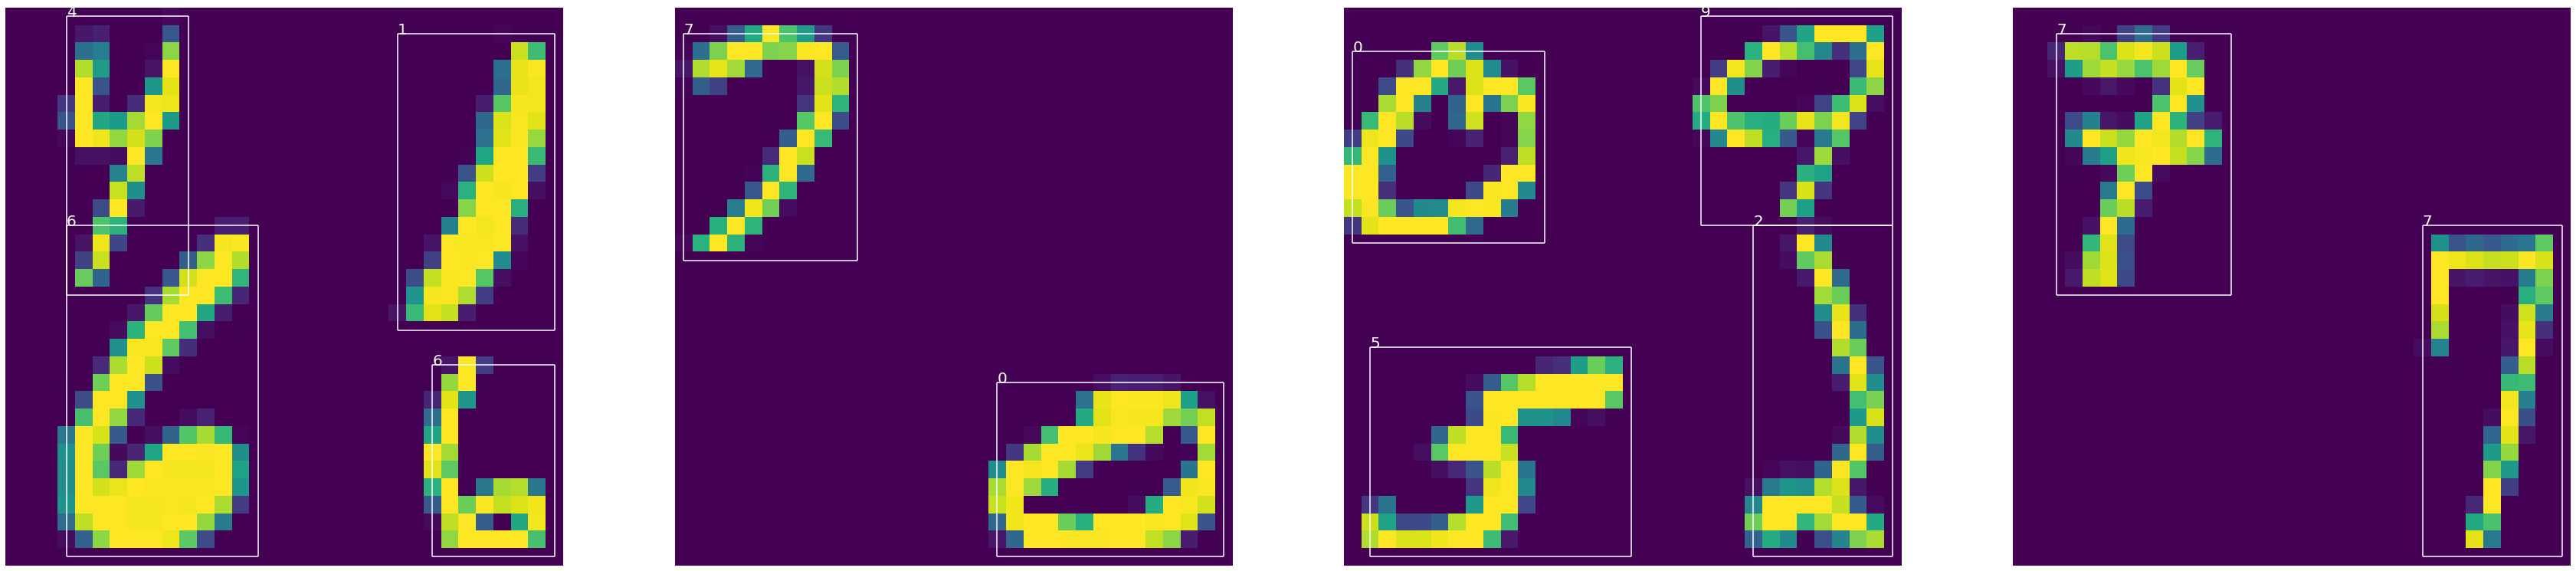

In [13]:
a,b,c = next(iter(trainloader))
fig = utils.imshow_with_bbox(a[:4],b[:4],c[:4])

In [14]:
model = SSD300(config, base_conv, aux_conv).to(config['device'])

There are 2124 priors in this model
Done initialization


In [15]:
bias = []
not_bias = []
for name, param in model.named_parameters():
    if param.requires_grad:
        if 'bias' in name:
            bias.append(param)
        else:
            not_bias.append(param)
optimizer = torch.optim.Adam([{'params': bias, 'lr': config['lr']*2}, 
                              {'params': not_bias}], 
                             lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, config['MultiStepLR_milestones'], gamma=config['gamma'], verbose=False)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, config=config)
plot_loss = []

#load checkpoint
if config['checkpoint']:
    print('Loaded checkpoint')
    checkpoint = torch.load(config['checkpoint'], map_location=config['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    plot_loss = checkpoint['plot_loss']


# train

In [ ]:
training_progress_bar = tqdm(range(config['n_epoch']))
epoch_progress_bar = tqdm(range(len(trainloader)))

for e in range(config['n_epoch']):
    training_progress_bar.update()
    epoch_progress_bar.reset()

    mean_loss = 0
    for img, boxes, labels in trainloader:
        epoch_progress_bar.update()
        # img: tensor [n, c=1, h, w]
        # boxes: list[n] of tensor[n_object, 4]
        # labels: list[n] of tensor[n_object]
        loc_output, cla_output, _ = model(img)
        loss = criterion(loc_output, cla_output, boxes, labels)
        
        optimizer.zero_grad()
        loss.backward()

        if config['clip_grad']:
            utils.clip_gradient(optimizer, config['clip_grad'])
        
        optimizer.step()
        mean_loss += loss.item()
        # break
    scheduler.step()
    mean_loss /= len(trainloader)
    plot_loss.append(mean_loss)
    
    if (e%config['print_frequency'] == config['print_frequency'] - 1) or (e==0):
        print(mean_loss)
        print(criterion.loc_loss, criterion.cla_loss)

if e % config['save_frequency'] == config['save_frequency'] - 1:
    plot_and_save(plot_loss, output_folder/'train_loss.png')
    plot_and_save(plot_loss[-5:], output_folder/'train_loss_tail.png')
    torch.save({'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'plot_loss': plot_loss}, output_folder/'checkpoint.pth')
    
    


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

1.6225479829311371
tensor(0.5369, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.8468, device='cuda:0', grad_fn=<DivBackward0>)
1.2438276533782482
tensor(0.4667, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.7197, device='cuda:0', grad_fn=<DivBackward0>)
1.0578556030243635
tensor(0.4162, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.6025, device='cuda:0', grad_fn=<DivBackward0>)
0.9406107573956252
tensor(0.3689, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.5274, device='cuda:0', grad_fn=<DivBackward0>)
0.8697241927683353
tensor(0.3509, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.4804, device='cuda:0', grad_fn=<DivBackward0>)
0.822994383573532
tensor(0.3384, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.4488, device='cuda:0', grad_fn=<DivBackward0>)
0.7907321594655514
tensor(0.3255, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.4220, device='cuda:0', grad_fn=<DivBackward0>)
0.7675595108419657
tensor(0.3191, device='cuda:0', grad_fn=<L1LossBack

In [ ]:
torch.save({'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'plot_loss': plot_loss}, output_folder/'checkpoint.pth')

# eval

In [ ]:
checkpoint = torch.load(output_folder/'checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
testset = MyDataset(p.cwd()/'data/test.pkl', device=config['device'])
testloader = torch.utils.data.DataLoader(testset, batch_size=100, collate_fn=testset.collate_fn, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


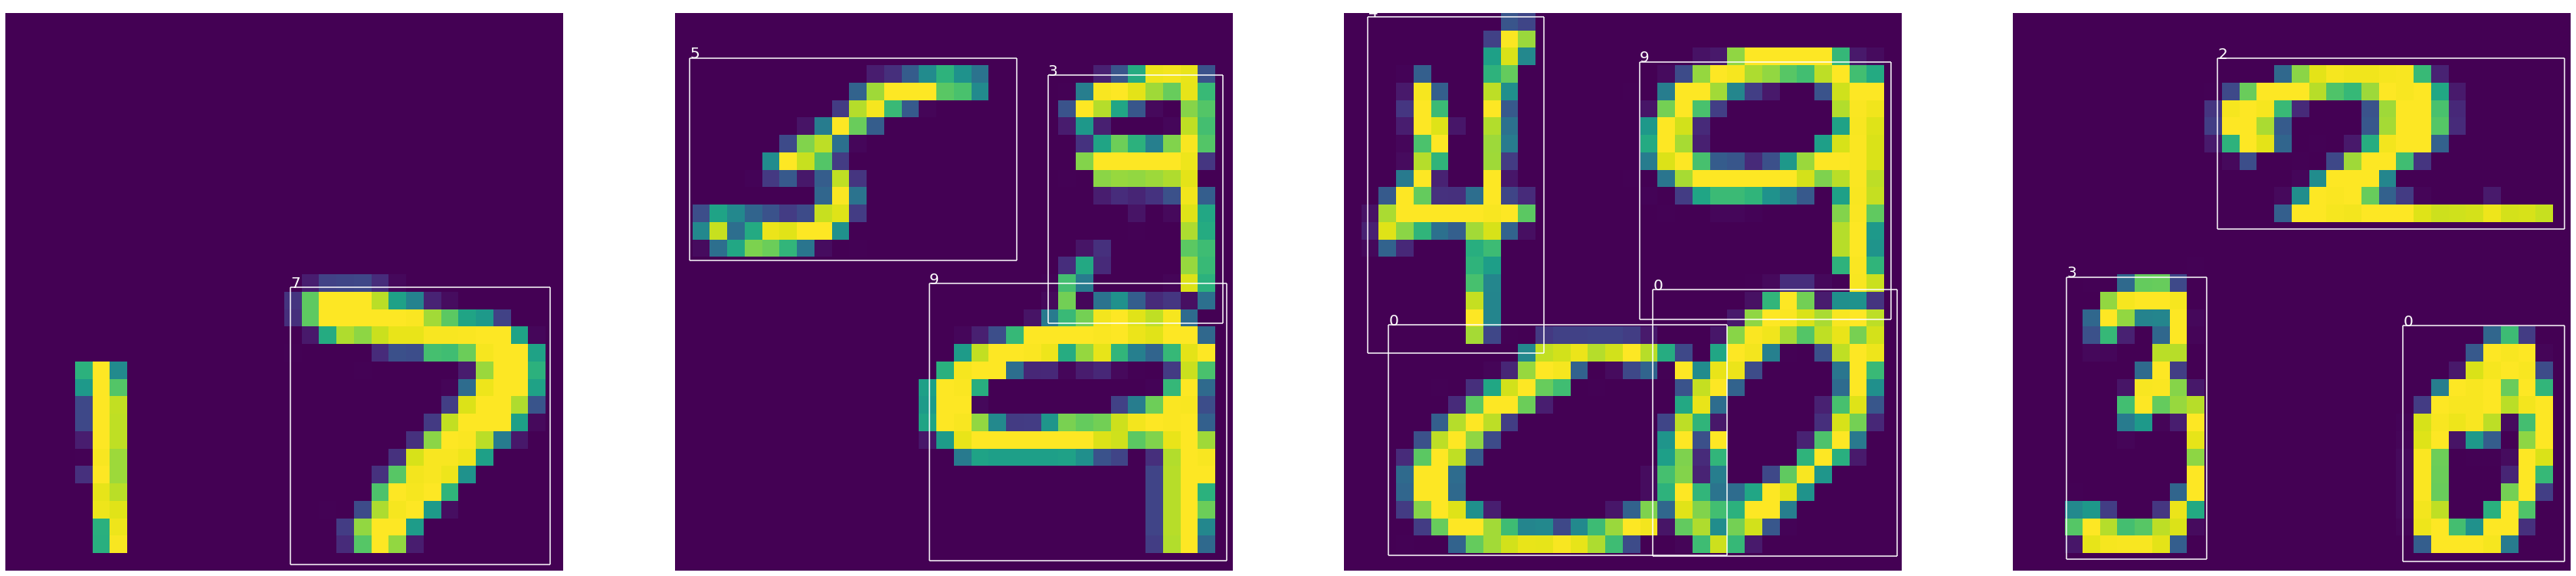

In [ ]:
model.eval()
img, boxes_gt, labels_gt = next(iter(testloader))
loc_output, cla_output, _ = model(img)
boxes_output, labels_output, scores_output = model.detect_object(loc_output, cla_output, min_score=0.4, max_overlap=0.45, top_k=200)
#plot detection in 4 samples
fig = imshow_with_bbox(img[:4], boxes_output[:4], labels_output[:4])

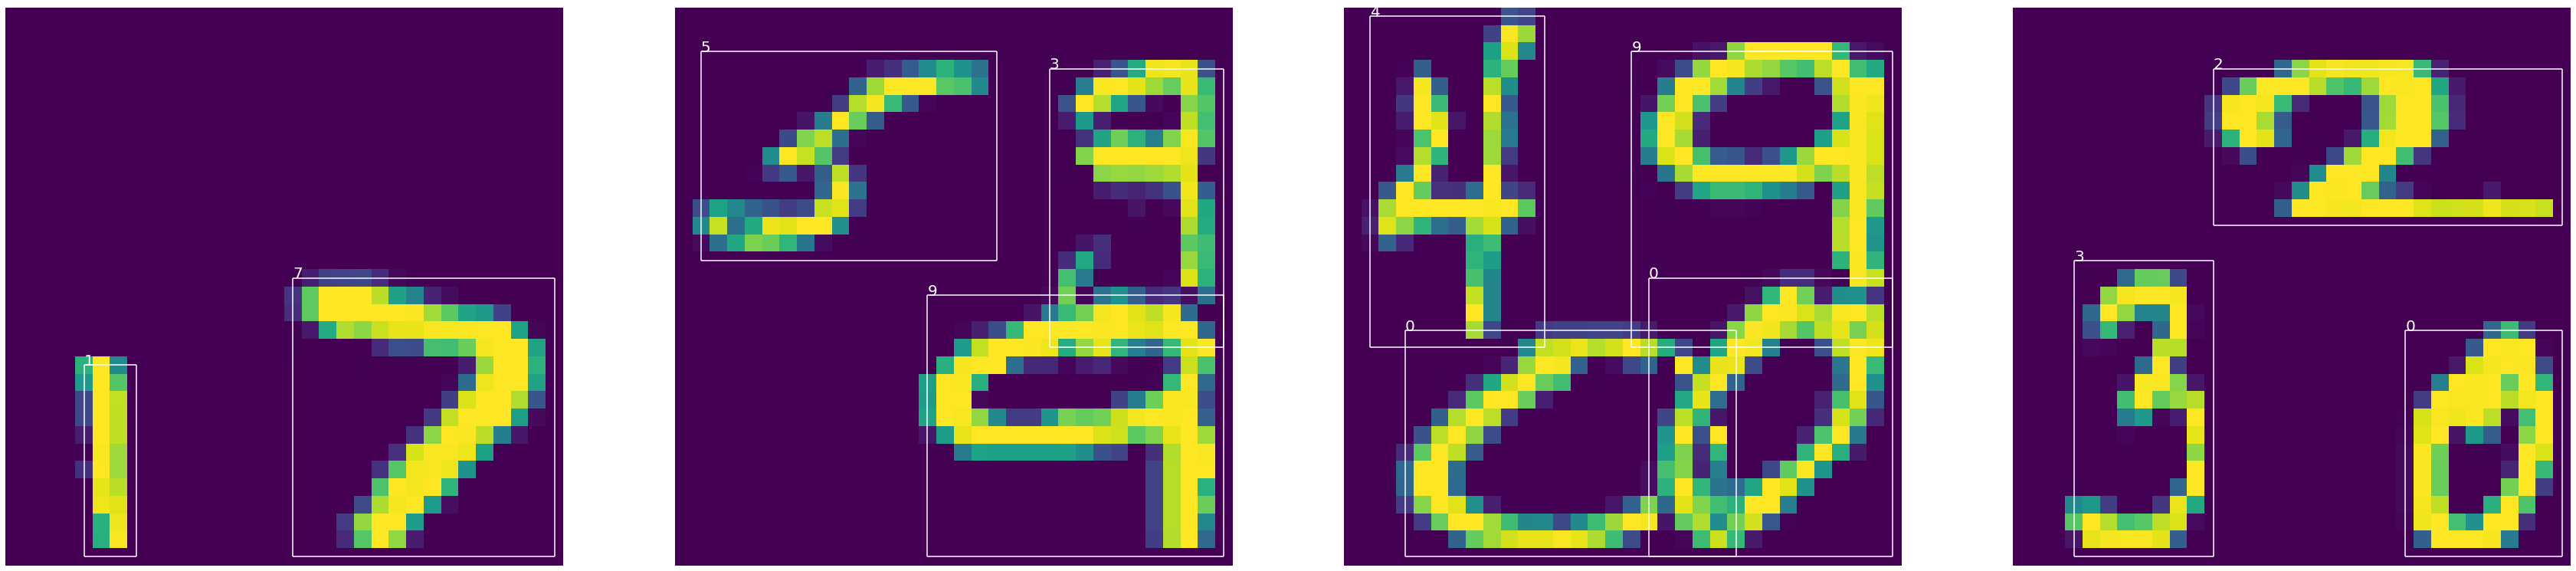

In [ ]:
# plot ground truth of those samples
_ = imshow_with_bbox(img[:4], boxes_gt[:4], labels_gt[:4])

In [ ]:
all_boxes_output = []
all_labels_output = []
all_scores_output = []
all_boxes_gt = []
all_labels_gt = []
all_difficulties_gt = []

model.eval()
with torch.no_grad():
    for images, boxes, labels in tqdm(testloader): #labels: list[n] of tensors[n_object]

        loc_output, cla_output, _ = model(images) #loc_output: tensor[n,n_p,4], cla_output: tensor[n, n_p, n_classes]
        boxes_output, labels_output, scores_output = model.detect_object(loc_output, cla_output, min_score=0.2, max_overlap=0.45, top_k=200)
        
        all_boxes_output.extend(boxes_output)
        all_labels_output.extend(labels_output)
        all_scores_output.extend(scores_output)
        
        all_boxes_gt.extend(boxes)
        all_labels_gt.extend(labels) 
        # break
all_difficulties_gt = [torch.zeros_like(i, dtype=torch.bool) for i in all_labels_gt]


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:251: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:253: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


In [ ]:
APs, mAP = utils.calculate_mAP(all_boxes_output, all_labels_output, all_scores_output, all_boxes_gt, all_labels_gt, all_difficulties_gt)

In [ ]:
APs

{'0': 0.900413453578949,
 '1': 0.70460045337677,
 '2': 0.8983807563781738,
 '3': 0.9028382897377014,
 '4': 0.9068259596824646,
 '5': 0.9053849577903748,
 '6': 0.9046807885169983,
 '7': 0.8945475816726685,
 '8': 0.9040240049362183,
 '9': 0.8957292437553406}

In [ ]:
mAP

0.8817425966262817